In [19]:
#common python packages
import numpy as np
import pandas as pd
import string
import random
import os
import pickle
import argparse
import wget
import math
import matplotlib.pyplot as plt
from datetime import datetime

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig


#machine learning packages
import sklearn
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

import tensorflow as tf
from tensorflow.python.framework import ops

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v8 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

import cv2

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [20]:
exp_file_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/fantom_enhancers/"
exp_file = exp_file_dir + "robust_enhancers.bed.mapped.hg38.bed"
NPC_sites = pybedtools.BedTool(exp_file)
print(NPC_sites.head(as_string=True))
print("Element Count: ", NPC_sites.count())
interval_lengths = [len(i) for i in NPC_sites]
print("Element Lengths: ", interval_lengths)

chr1	922876	923268	chr1:858256-858648
chr1	983069	983175	chr1:918449-918555
chr1	1006411	1006755	chr1:941791-942135
chr1	1010389	1010654	chr1:945769-946034
chr1	1021183	1021432	chr1:956563-956812
chr1	1069913	1070167	chr1:1005293-1005547
chr1	1079454	1079715	chr1:1014834-1015095
chr1	1125525	1125715	chr1:1060905-1061095
chr1	1128534	1128731	chr1:1063914-1064111
chr1	1158230	1158578	chr1:1093610-1093958

Element Count:  38548
Element Lengths:  [392, 106, 344, 265, 249, 254, 261, 190, 197, 348, 342, 388, 479, 667, 350, 797, 11, 315, 23, 695, 148, 33, 362, 386, 310, 206, 62, 283, 186, 671, 122, 243, 214, 144, 680, 217, 494, 468, 207, 151, 149, 392, 541, 625, 326, 496, 421, 154, 366, 335, 389, 407, 220, 392, 194, 446, 78, 54, 366, 353, 151, 137, 319, 271, 386, 304, 120, 290, 326, 231, 175, 376, 372, 228, 71, 345, 163, 290, 126, 423, 366, 229, 218, 304, 190, 247, 139, 20, 346, 504, 129, 293, 103, 223, 394, 359, 246, 359, 530, 212, 397, 434, 358, 376, 271, 631, 490, 317, 138, 399, 264, 361, 

In [21]:
#expand annotations to 4kb
df = pd.read_csv(exp_file, sep="\t", usecols=[0,1,2], header=None)
new_start_list = []
new_stop_list = []
for index, row in df.iterrows():
    interval_len = int(row[2]) - int(row[1])
    new_start = int(row[1] - ((4000 - interval_len) / 2))
    new_start_list.append(new_start)
    new_stop_list.append(new_start + 4000)
df[1] = new_start_list
df[2] = new_stop_list
formatted_exp_name = exp_file.replace(".mapped.hg38.bed", ".4kb_expanded.hg38.bed")
df.to_csv(formatted_exp_name, sep="\t", header=None, index=None)
df

for index, row in df.iterrows():
    print(row[0] + ":" + str(row[1]) + "-" + str(row[2]))

chr1:921072-925072
chr1:981122-985122
chr1:1004583-1008583
chr1:1008521-1012521
chr1:1019307-1023307
chr1:1068040-1072040
chr1:1077584-1081584
chr1:1123620-1127620
chr1:1126632-1130632
chr1:1156404-1160404
chr1:1187391-1191391
chr1:1198889-1202889
chr1:1199526-1203526
chr1:1206484-1210484
chr1:1236181-1240181
chr1:1358553-1362553
chr1:1411310-1415310
chr1:1431248-1435248
chr1:1519307-1523307
chr1:1780928-1784928
chr1:1838743-1842743
chr1:1860406-1864406
chr1:1881504-1885504
chr1:1907203-1911203
chr1:2018766-2022766
chr1:2045395-2049395
chr1:2126524-2130524
chr1:2149431-2153431
chr1:2206805-2210805
chr1:2229221-2233221
chr1:2238446-2242446
chr1:2238824-2242824
chr1:2244283-2248283
chr1:2257163-2261163
chr1:2288769-2292769
chr1:2297347-2301347
chr1:2298499-2302499
chr1:2299223-2303223
chr1:2313220-2317220
chr1:2320258-2324258
chr1:2320716-2324716
chr1:2473246-2477246
chr1:2545107-2549107
chr1:2568661-2572661
chr1:2571759-2575759
chr1:2576511-2580511
chr1:2641114-2645114
chr1:2854071-2858

chr1:41034281-41038281
chr1:41096498-41100498
chr1:41165646-41169646
chr1:41183312-41187312
chr1:41294480-41298480
chr1:41358361-41362361
chr1:41363953-41367953
chr1:41417550-41421550
chr1:41447064-41451064
chr1:41447796-41451796
chr1:41484473-41488473
chr1:41494364-41498364
chr1:41514248-41518248
chr1:41527106-41531106
chr1:41606260-41610260
chr1:41614416-41618416
chr1:41660650-41664650
chr1:41673582-41677582
chr1:41682281-41686281
chr1:41697139-41701139
chr1:41725561-41729561
chr1:41733868-41737868
chr1:41736591-41740591
chr1:41737377-41741377
chr1:41739349-41743349
chr1:41750152-41754152
chr1:41762812-41766812
chr1:41763299-41767299
chr1:41766714-41770714
chr1:41781399-41785399
chr1:41801190-41805190
chr1:41805006-41809006
chr1:41807854-41811854
chr1:41809538-41813538
chr1:41861057-41865057
chr1:41866968-41870968
chr1:41886778-41890778
chr1:41889408-41893408
chr1:41896349-41900349
chr1:41898823-41902823
chr1:41917839-41921839
chr1:41918110-41922110
chr1:42044679-42048679
chr1:423070

chr1:110419443-110423443
chr1:110432080-110436080
chr1:110509017-110513017
chr1:110513301-110517301
chr1:110618143-110622143
chr1:110618871-110622871
chr1:110626013-110630013
chr1:110626491-110630491
chr1:110633040-110637040
chr1:110634455-110638455
chr1:110638249-110642249
chr1:110643627-110647627
chr1:110645586-110649586
chr1:110646648-110650648
chr1:110666698-110670698
chr1:110668342-110672342
chr1:110685597-110689597
chr1:110705391-110709391
chr1:110707345-110711345
chr1:110711432-110715432
chr1:110718156-110722156
chr1:110721017-110725017
chr1:110785369-110789369
chr1:110872706-110876706
chr1:110922604-110926604
chr1:110944591-110948591
chr1:111190908-111194908
chr1:111191225-111195225
chr1:111200916-111204916
chr1:111213049-111217049
chr1:111214151-111218151
chr1:111215371-111219371
chr1:111217878-111221878
chr1:111219921-111223921
chr1:111437393-111441393
chr1:111469059-111473059
chr1:111503963-111507963
chr1:111505697-111509697
chr1:111513849-111517849
chr1:111514363-111518363


chr1:183865674-183869674
chr1:183875587-183879587
chr1:183880568-183884568
chr1:183883494-183887494
chr1:183884053-183888053
chr1:183890512-183894512
chr1:183894721-183898721
chr1:183906321-183910321
chr1:183909538-183913538
chr1:183955742-183959742
chr1:183965615-183969615
chr1:184034500-184038500
chr1:184062735-184066735
chr1:184152524-184156524
chr1:184157368-184161368
chr1:184158486-184162486
chr1:184159327-184163327
chr1:184161847-184165847
chr1:184192502-184196502
chr1:184294612-184298612
chr1:184386647-184390647
chr1:184416865-184420865
chr1:184450456-184454456
chr1:184504712-184508712
chr1:184633477-184637477
chr1:184636089-184640089
chr1:184753880-184757880
chr1:184802481-184806481
chr1:184838802-184842802
chr1:184841890-184845890
chr1:184857586-184861586
chr1:184865150-184869150
chr1:184951787-184955787
chr1:184953872-184957872
chr1:185015566-185019566
chr1:185138841-185142841
chr1:185156358-185160358
chr1:185279412-185283412
chr1:185282732-185286732
chr1:185326436-185330436


chr1:229198103-229202103
chr1:229203520-229207520
chr1:229219897-229223897
chr1:229228025-229232025
chr1:229228853-229232853
chr1:229251257-229255257
chr1:229272079-229276079
chr1:229406861-229410861
chr1:229409242-229413242
chr1:229432860-229436860
chr1:229553372-229557372
chr1:229555426-229559426
chr1:229687465-229691465
chr1:229923349-229927349
chr1:229951943-229955943
chr1:230082856-230086856
chr1:230102974-230106974
chr1:230104041-230108041
chr1:230110524-230114524
chr1:230111930-230115930
chr1:230121349-230125349
chr1:230141870-230145870
chr1:230144371-230148371
chr1:230152176-230156176
chr1:230270096-230274096
chr1:230422295-230426295
chr1:230456702-230460702
chr1:230457617-230461617
chr1:230494023-230498023
chr1:230506170-230510170
chr1:230507774-230511774
chr1:230554639-230558639
chr1:230806174-230810174
chr1:230864601-230868601
chr1:230899161-230903161
chr1:230900546-230904546
chr1:230975492-230979492
chr1:231091614-231095614
chr1:231209671-231213671
chr1:231290512-231294512


chr10:21755850-21759850
chr10:21762989-21766989
chr10:21952209-21956209
chr10:22131873-22135873
chr10:22228645-22232645
chr10:22249338-22253338
chr10:22264862-22268862
chr10:22278702-22282702
chr10:22331387-22335387
chr10:22332517-22336517
chr10:22333427-22337427
chr10:22334892-22338892
chr10:22338330-22342330
chr10:22338974-22342974
chr10:22432073-22436073
chr10:22474190-22478190
chr10:22526331-22530331
chr10:22595400-22599400
chr10:22603403-22607403
chr10:22604251-22608251
chr10:22609902-22613902
chr10:22613813-22617813
chr10:22628678-22632678
chr10:22629853-22633853
chr10:22847479-22851479
chr10:23053863-23057863
chr10:23278624-23282624
chr10:23361701-23365701
chr10:23410351-23414351
chr10:23411788-23415788
chr10:23430841-23434841
chr10:23431944-23435944
chr10:23446985-23450985
chr10:23510556-23514556
chr10:23555280-23559280
chr10:23641248-23645248
chr10:23711334-23715334
chr10:24007392-24011392
chr10:24036949-24040949
chr10:24208150-24212150
chr10:24232859-24236859
chr10:24449549-2

chr10:79248646-79252646
chr10:79264595-79268595
chr10:79265877-79269877
chr10:79266524-79270524
chr10:79267101-79271101
chr10:79268542-79272542
chr10:79269064-79273064
chr10:79272370-79276370
chr10:79272892-79276892
chr10:79280588-79284588
chr10:79284586-79288586
chr10:79286600-79290600
chr10:79297810-79301810
chr10:79309862-79313862
chr10:79316189-79320189
chr10:79317171-79321171
chr10:79319394-79323394
chr10:79321491-79325491
chr10:79324248-79328248
chr10:79326943-79330943
chr10:79329312-79333312
chr10:79329930-79333930
chr10:79343012-79347012
chr10:79343506-79347506
chr10:79377129-79381129
chr10:79397701-79401701
chr10:79417762-79421762
chr10:79430016-79434016
chr10:79925343-79929343
chr10:79937054-79941054
chr10:80102583-80106583
chr10:80184755-80188755
chr10:80194542-80198542
chr10:80198000-80202000
chr10:80199626-80203626
chr10:80201432-80205432
chr10:80319441-80323441
chr10:80390456-80394456
chr10:80414456-80418456
chr10:80447386-80451386
chr10:80450118-80454118
chr10:80453104-8

chr11:1913618-1917618
chr11:1959658-1963658
chr11:1965832-1969832
chr11:1966783-1970783
chr11:1968040-1972040
chr11:1985375-1989375
chr11:1986677-1990677
chr11:2141067-2145067
chr11:2173871-2177871
chr11:2175363-2179363
chr11:2177100-2181100
chr11:2189317-2193317
chr11:2200659-2204659
chr11:2203068-2207068
chr11:2211600-2215600
chr11:2214796-2218796
chr11:2263727-2267727
chr11:2285125-2289125
chr11:2379032-2383032
chr11:2442014-2446014
chr11:2445181-2449181
chr11:2461486-2465486
chr11:2465508-2469508
chr11:2479049-2483049
chr11:2480476-2484476
chr11:2481736-2485736
chr11:2575148-2579148
chr11:2596741-2600741
chr11:2601045-2605045
chr11:2620950-2624950
chr11:2631951-2635951
chr11:2646853-2650853
chr11:2694677-2698677
chr11:2723899-2727899
chr11:2767265-2771265
chr11:2767802-2771802
chr11:2776873-2780873
chr11:2824122-2828122
chr11:2824502-2828502
chr11:2896945-2900945
chr11:2928359-2932359
chr11:2931087-2935087
chr11:2938720-2942720
chr11:2965838-2969838
chr11:2998228-3002228
chr11:3012

chr11:69009193-69013193
chr11:69028501-69032501
chr11:69039056-69043056
chr11:69049754-69053754
chr11:69054373-69058373
chr11:69078424-69082424
chr11:69138858-69142858
chr11:69139916-69143916
chr11:69155428-69159428
chr11:69272794-69276794
chr11:69298376-69302376
chr11:69299794-69303794
chr11:69300126-69304126
chr11:69309417-69313417
chr11:69310145-69314145
chr11:69319959-69323959
chr11:69338229-69342229
chr11:69366295-69370295
chr11:69380565-69384565
chr11:69441495-69445495
chr11:69508657-69512657
chr11:69529322-69533322
chr11:69537981-69541981
chr11:69636109-69640109
chr11:69770195-69774195
chr11:69838826-69842826
chr11:69942106-69946106
chr11:69942828-69946828
chr11:69946625-69950625
chr11:69947586-69951586
chr11:69964008-69968008
chr11:69970573-69974573
chr11:70009497-70013497
chr11:70046887-70050887
chr11:70057965-70061965
chr11:70078991-70082991
chr11:70117931-70121931
chr11:70157862-70161862
chr11:70231527-70235527
chr11:70259440-70263440
chr11:70296165-70300165
chr11:70311226-7

chr11:128714936-128718936
chr11:128716984-128720984
chr11:128718601-128722601
chr11:128725098-128729098
chr11:128734150-128738150
chr11:128737043-128741043
chr11:128885566-128889566
chr11:128901874-128905874
chr11:129075461-129079461
chr11:129141506-129145506
chr11:129230722-129234722
chr11:129329261-129333261
chr11:129374740-129378740
chr11:129378237-129382237
chr11:129380087-129384087
chr11:129388733-129392733
chr11:129395696-129399696
chr11:129443325-129447325
chr11:129635628-129639628
chr11:129636395-129640395
chr11:129637515-129641515
chr11:129641242-129645242
chr11:129729651-129733651
chr11:129823603-129827603
chr11:129844660-129848660
chr11:129845243-129849243
chr11:129852123-129856123
chr11:129858443-129862443
chr11:129860043-129864043
chr11:129909492-129913492
chr11:129928414-129932414
chr11:130040236-130044236
chr11:130041702-130045702
chr11:130048474-130052474
chr11:130049124-130053124
chr11:130053696-130057696
chr11:130070349-130074349
chr11:130122262-130126262
chr11:130144

chr12:51882786-51886786
chr12:51884111-51888111
chr12:51895438-51899438
chr12:51904194-51908194
chr12:51969284-51973284
chr12:51971073-51975073
chr12:52023024-52027024
chr12:52023834-52027834
chr12:52027885-52031885
chr12:52030579-52034579
chr12:52031071-52035071
chr12:52042515-52046515
chr12:52043072-52047072
chr12:52044044-52048044
chr12:52062291-52066291
chr12:52116661-52120661
chr12:52143731-52147731
chr12:52145461-52149461
chr12:52146684-52150684
chr12:52147697-52151697
chr12:52150147-52154147
chr12:52163627-52167627
chr12:52179927-52183927
chr12:52187194-52191194
chr12:52189048-52193048
chr12:52192147-52196147
chr12:52192411-52196411
chr12:52193296-52197296
chr12:52196087-52200087
chr12:52196838-52200838
chr12:52198425-52202425
chr12:52199561-52203561
chr12:52200465-52204465
chr12:52201361-52205361
chr12:52202016-52206016
chr12:52228420-52232420
chr12:52229129-52233129
chr12:52278496-52282496
chr12:52279084-52283084
chr12:52419466-52423466
chr12:52492744-52496744
chr12:52493606-5

chr12:104670732-104674732
chr12:104681092-104685092
chr12:104693660-104697660
chr12:104718697-104722697
chr12:104781549-104785549
chr12:104888597-104892597
chr12:104928803-104932803
chr12:104969542-104973542
chr12:105081735-105085735
chr12:105090534-105094534
chr12:105224443-105228443
chr12:105315528-105319528
chr12:105320267-105324267
chr12:105416401-105420401
chr12:105466631-105470631
chr12:105483460-105487460
chr12:105504437-105508437
chr12:105920750-105924750
chr12:105932507-105936507
chr12:105985663-105989663
chr12:106006085-106010085
chr12:106028144-106032144
chr12:106139657-106143657
chr12:106197889-106201889
chr12:106225719-106229719
chr12:106244334-106248334
chr12:106268061-106272061
chr12:106268383-106272383
chr12:106278220-106282220
chr12:106286637-106290637
chr12:106298945-106302945
chr12:106580056-106584056
chr12:106584447-106588447
chr12:106585346-106589346
chr12:106758307-106762307
chr12:106981933-106985933
chr12:107329265-107333265
chr12:107350400-107354400
chr12:107658

chr13:43967101-43971101
chr13:44044535-44048535
chr13:44110845-44114845
chr13:44164439-44168439
chr13:44242449-44246449
chr13:44257260-44261260
chr13:44257891-44261891
chr13:44262527-44266527
chr13:44269233-44273233
chr13:44270785-44274785
chr13:44272479-44276479
chr13:44290767-44294767
chr13:44293121-44297121
chr13:44299415-44303415
chr13:44304677-44308677
chr13:44306095-44310095
chr13:44309041-44313041
chr13:44311084-44315084
chr13:44348981-44352981
chr13:44618269-44622269
chr13:44712271-44716271
chr13:44757039-44761039
chr13:44762417-44766417
chr13:44916403-44920403
chr13:45053728-45057728
chr13:45135291-45139291
chr13:45197932-45201932
chr13:45203383-45207383
chr13:45207486-45211486
chr13:45237110-45241110
chr13:45365501-45369501
chr13:45519515-45523515
chr13:45593470-45597470
chr13:45668400-45672400
chr13:45693606-45697606
chr13:45763630-45767630
chr13:46100573-46104573
chr13:46112760-46116760
chr13:46160296-46164296
chr13:46168915-46172915
chr13:46169355-46173355
chr13:46171753-4

chr14:35331944-35335944
chr14:35334732-35338732
chr14:35337996-35341996
chr14:35339737-35343737
chr14:35354184-35358184
chr14:35357850-35361850
chr14:35363553-35367553
chr14:35364368-35368368
chr14:35366839-35370839
chr14:35382482-35386482
chr14:35383766-35387766
chr14:35384816-35388816
chr14:35389143-35393143
chr14:35394057-35398057
chr14:35398883-35402883
chr14:35404676-35408676
chr14:35414291-35418291
chr14:35415042-35419042
chr14:35806241-35810241
chr14:36136078-36140078
chr14:36147290-36151290
chr14:36170249-36174249
chr14:36171263-36175263
chr14:36173081-36177081
chr14:36506377-36510377
chr14:36512821-36516821
chr14:36648687-36652687
chr14:36839700-36843700
chr14:36846318-36850318
chr14:36974694-36978694
chr14:36994134-36998134
chr14:36997973-37001973
chr14:36998659-37002659
chr14:37397714-37401714
chr14:37509613-37513613
chr14:37581982-37585982
chr14:37586749-37590749
chr14:38063336-38067336
chr14:38143729-38147729
chr14:38250107-38254107
chr14:38490330-38494330
chr14:38651686-3

chr14:91362278-91366278
chr14:91365384-91369384
chr14:91385345-91389345
chr14:91395671-91399671
chr14:91401051-91405051
chr14:91403538-91407538
chr14:91408163-91412163
chr14:91411796-91415796
chr14:91458545-91462545
chr14:91519569-91523569
chr14:91743559-91747559
chr14:91978329-91982329
chr14:91983199-91987199
chr14:92103869-92107869
chr14:92384822-92388822
chr14:92390916-92394916
chr14:92457824-92461824
chr14:92459340-92463340
chr14:92464253-92468253
chr14:92470136-92474136
chr14:92471745-92475745
chr14:92474004-92478004
chr14:92502024-92506024
chr14:92504501-92508501
chr14:92505526-92509526
chr14:92525934-92529934
chr14:92528019-92532019
chr14:92529486-92533486
chr14:92562541-92566541
chr14:92566880-92570880
chr14:92576380-92580380
chr14:92581229-92585229
chr14:92582946-92586946
chr14:92646031-92650031
chr14:92651558-92655558
chr14:92652339-92656339
chr14:92653519-92657519
chr14:92664089-92668089
chr14:92722618-92726618
chr14:92724347-92728347
chr14:92725558-92729558
chr14:92783914-9

chr15:59184114-59188114
chr15:59198248-59202248
chr15:59236077-59240077
chr15:59242597-59246597
chr15:59272344-59276344
chr15:59282105-59286105
chr15:59293157-59297157
chr15:59298485-59302485
chr15:59348327-59352327
chr15:59372304-59376304
chr15:59392890-59396890
chr15:59404541-59408541
chr15:59411034-59415034
chr15:59522459-59526459
chr15:59553983-59557983
chr15:59568553-59572553
chr15:59684525-59688525
chr15:59770313-59774313
chr15:59847943-59851943
chr15:60043116-60047116
chr15:60176796-60180796
chr15:60253576-60257576
chr15:60405620-60409620
chr15:60406632-60410632
chr15:60524380-60528380
chr15:60545056-60549056
chr15:60546318-60550318
chr15:60561756-60565756
chr15:60571977-60575977
chr15:60580493-60584493
chr15:60587479-60591479
chr15:60589339-60593339
chr15:60633659-60637659
chr15:60643381-60647381
chr15:60692522-60696522
chr15:60696007-60700007
chr15:60719988-60723988
chr15:60757179-60761179
chr15:60797001-60801001
chr15:60819266-60823266
chr15:60838992-60842992
chr15:61210988-6

chr15:101437621-101441621
chr15:101444353-101448353
chr15:101444909-101448909
chr15:101453619-101457619
chr15:101481232-101485232
chr15:101518521-101522521
chr15:101660285-101664285
chr15:101671464-101675464
chr16:33293-37293
chr16:69708-73708
chr16:79103-83103
chr16:99266-103266
chr16:103092-107092
chr16:141155-145155
chr16:147388-151388
chr16:305883-309883
chr16:322623-326623
chr16:323103-327103
chr16:325592-329592
chr16:329780-333780
chr16:456012-460012
chr16:523675-527675
chr16:526952-530952
chr16:560138-564138
chr16:564135-568135
chr16:591797-595797
chr16:757754-761754
chr16:806928-810928
chr16:994858-998858
chr16:1024590-1028590
chr16:1080550-1084550
chr16:1081173-1085173
chr16:1098232-1102232
chr16:1123676-1127676
chr16:1127526-1131526
chr16:1157589-1161589
chr16:1158560-1162560
chr16:1170241-1174241
chr16:1187319-1191319
chr16:1243730-1247730
chr16:1289191-1293191
chr16:1292458-1296458
chr16:1330008-1334008
chr16:1467843-1471843
chr16:1529238-1533238
chr16:1533740-1537740
chr16

chr16:69396497-69400497
chr16:69406645-69410645
chr16:69408468-69412468
chr16:69470564-69474564
chr16:69480802-69484802
chr16:69512547-69516547
chr16:69520915-69524915
chr16:69527731-69531731
chr16:69528826-69532826
chr16:69565317-69569317
chr16:69715425-69719425
chr16:69725934-69729934
chr16:69755135-69759135
chr16:69761256-69765256
chr16:69783418-69787418
chr16:70024463-70028463
chr16:70320899-70324899
chr16:70391843-70395843
chr16:70415346-70419346
chr16:70426363-70430363
chr16:70429063-70433063
chr16:70676852-70680852
chr16:70690035-70694035
chr16:70713326-70717326
chr16:70723439-70727439
chr16:70733937-70737937
chr16:70735684-70739684
chr16:70744162-70748162
chr16:70744894-70748894
chr16:70882613-70886613
chr16:70938193-70942193
chr16:70944269-70948269
chr16:71010861-71014861
chr16:71087742-71091742
chr16:71365335-71369335
chr16:71545049-71549049
chr16:71705636-71709636
chr16:71895154-71899154
chr16:72172882-72176882
chr16:72187968-72191968
chr16:72200203-72204203
chr16:72201670-7

chr17:16470532-16474532
chr17:16483243-16487243
chr17:16534926-16538926
chr17:16582352-16586352
chr17:16891515-16895515
chr17:16968591-16972591
chr17:17019458-17023458
chr17:17043111-17047111
chr17:17148778-17152778
chr17:17193492-17197492
chr17:17303725-17307725
chr17:17406665-17410665
chr17:17414639-17418639
chr17:17431104-17435104
chr17:17433528-17437528
chr17:17515271-17519271
chr17:17534074-17538074
chr17:17565324-17569324
chr17:17588425-17592425
chr17:17690081-17694081
chr17:17692535-17696535
chr17:17710767-17714767
chr17:17736392-17740392
chr17:17739555-17743555
chr17:17748877-17752877
chr17:17750399-17754399
chr17:17772658-17776658
chr17:17838243-17842243
chr17:17847296-17851296
chr17:17872653-17876653
chr17:17912095-17916095
chr17:17933828-17937828
chr17:17956223-17960223
chr17:17969589-17973589
chr17:18127163-18131163
chr17:18179510-18183510
chr17:18295267-18299267
chr17:18299262-18303262
chr17:18337448-18341448
chr17:18899024-18903024
chr17:18915379-18919379
chr17:18920322-1

chr17:62881064-62885064
chr17:62891165-62895165
chr17:62893874-62897874
chr17:62897435-62901435
chr17:63199923-63203923
chr17:63220154-63224154
chr17:63273568-63277568
chr17:63277100-63281100
chr17:63277998-63281998
chr17:63291601-63295601
chr17:63352200-63356200
chr17:63434831-63438831
chr17:63458949-63462949
chr17:63549720-63553720
chr17:63707918-63711918
chr17:63841693-63845693
chr17:63925599-63929599
chr17:63931744-63935744
chr17:63986820-63990820
chr17:64020762-64024762
chr17:64022348-64026348
chr17:64023077-64027077
chr17:64055069-64059069
chr17:64059484-64063484
chr17:64061173-64065173
chr17:64072501-64076501
chr17:64075542-64079542
chr17:64080255-64084255
chr17:64081992-64085992
chr17:64089304-64093304
chr17:64090228-64094228
chr17:64173017-64177017
chr17:64177269-64181269
chr17:64179655-64183655
chr17:64260346-64264346
chr17:64324873-64328873
chr17:64329585-64333585
chr17:64330065-64334065
chr17:64330508-64334508
chr17:64489434-64493434
chr17:64493452-64497452
chr17:64528326-6

chr18:9546335-9550335
chr18:9552577-9556577
chr18:9641717-9645717
chr18:9647023-9651023
chr18:9656265-9660265
chr18:9709862-9713862
chr18:9740811-9744811
chr18:9741779-9745779
chr18:9752028-9756028
chr18:9753823-9757823
chr18:9756344-9760344
chr18:9760688-9764688
chr18:9769387-9773387
chr18:9770107-9774107
chr18:9780588-9784588
chr18:9810208-9814208
chr18:9822536-9826536
chr18:9826414-9830414
chr18:9827314-9831314
chr18:9847662-9851662
chr18:9853872-9857872
chr18:9854239-9858239
chr18:9864278-9868278
chr18:9868003-9872003
chr18:9875456-9879456
chr18:9897217-9901217
chr18:9913252-9917252
chr18:10039239-10043239
chr18:10055932-10059932
chr18:10070961-10074961
chr18:10084638-10088638
chr18:10121274-10125274
chr18:10128762-10132762
chr18:10131756-10135756
chr18:10199530-10203530
chr18:10211665-10215665
chr18:10288350-10292350
chr18:10295341-10299341
chr18:10308761-10312761
chr18:10399733-10403733
chr18:10456756-10460756
chr18:10473916-10477916
chr18:10474640-10478640
chr18:10541267-1054526

chr19:931360-935360
chr19:933216-937216
chr19:945834-949834
chr19:951392-955392
chr19:953107-957107
chr19:994568-998568
chr19:1014784-1018784
chr19:1026542-1030542
chr19:1067335-1071335
chr19:1083356-1087356
chr19:1099957-1103957
chr19:1124294-1128294
chr19:1131279-1135279
chr19:1131704-1135704
chr19:1149156-1153156
chr19:1150325-1154325
chr19:1159838-1163838
chr19:1171053-1175053
chr19:1173498-1177498
chr19:1182056-1186056
chr19:1238384-1242384
chr19:1251196-1255196
chr19:1263938-1267938
chr19:1264579-1268579
chr19:1282645-1286645
chr19:1406652-1410652
chr19:1410053-1414053
chr19:1443368-1447368
chr19:1452007-1456007
chr19:1520996-1524996
chr19:1631073-1635073
chr19:1656066-1660066
chr19:1667246-1671246
chr19:1723799-1727799
chr19:1745376-1749376
chr19:1853505-1857505
chr19:1893550-1897550
chr19:1900134-1904134
chr19:1907921-1911921
chr19:1940451-1944451
chr19:1940843-1944843
chr19:1941253-1945253
chr19:2030491-2034491
chr19:2048093-2052093
chr19:2054679-2058679
chr19:2057887-2061887


chr19:40781252-40785252
chr19:40796258-40800258
chr19:41134566-41138566
chr19:41193850-41197850
chr19:41194309-41198309
chr19:41221603-41225603
chr19:41223812-41227812
chr19:41263726-41267726
chr19:41287624-41291624
chr19:41294847-41298847
chr19:41295700-41299700
chr19:41296381-41300381
chr19:41306653-41310653
chr19:41319968-41323968
chr19:41324180-41328180
chr19:41327054-41331054
chr19:41407850-41411850
chr19:41491698-41495698
chr19:41528845-41532845
chr19:41529757-41533757
chr19:41544503-41548503
chr19:41589828-41593828
chr19:41636795-41640795
chr19:41733410-41737410
chr19:41783824-41787824
chr19:41797664-41801664
chr19:41799153-41803153
chr19:41799982-41803982
chr19:41800958-41804958
chr19:41802491-41806491
chr19:41873647-41877647
chr19:41876084-41880084
chr19:41913964-41917964
chr19:41923312-41927312
chr19:41934707-41938707
chr19:41938342-41942342
chr19:41943649-41947649
chr19:41987920-41991920
chr19:41995228-41999228
chr19:42008529-42012529
chr19:42026339-42030339
chr19:42100807-4

chr2:23050496-23054496
chr2:23187947-23191947
chr2:23385256-23389256
chr2:23457100-23461100
chr2:23558280-23562280
chr2:23677268-23681268
chr2:24009609-24013609
chr2:24099555-24103555
chr2:24266913-24270913
chr2:24363220-24367220
chr2:24480862-24484862
chr2:24488652-24492652
chr2:24717202-24721202
chr2:24859673-24863673
chr2:24872073-24876073
chr2:24883885-24887885
chr2:24933858-24937858
chr2:25127435-25131435
chr2:25214149-25218149
chr2:25248924-25252924
chr2:25257822-25261822
chr2:25271553-25275553
chr2:25275270-25279270
chr2:25277431-25281431
chr2:25284180-25288180
chr2:25292883-25296883
chr2:25293284-25297284
chr2:25303397-25307397
chr2:25421448-25425448
chr2:25451393-25455393
chr2:25555816-25559816
chr2:25556510-25560510
chr2:25564913-25568913
chr2:25650001-25654001
chr2:25995921-25999921
chr2:26000256-26004256
chr2:26000829-26004829
chr2:26001214-26005214
chr2:26007057-26011057
chr2:26010711-26014711
chr2:26016296-26020296
chr2:26033490-26037490
chr2:26066812-26070812
chr2:262979

chr2:73004653-73008653
chr2:73109624-73113624
chr2:73174011-73178011
chr2:73175033-73179033
chr2:73384641-73388641
chr2:73819468-73823468
chr2:73831214-73835214
chr2:73855037-73859037
chr2:73892046-73896046
chr2:73902124-73906124
chr2:73924049-73928049
chr2:73977210-73981210
chr2:74068416-74072416
chr2:74069450-74073450
chr2:74179931-74183931
chr2:74183585-74187585
chr2:74217728-74221728
chr2:74418665-74422665
chr2:74536664-74540664
chr2:74564838-74568838
chr2:74572125-74576125
chr2:74575769-74579769
chr2:74582564-74586564
chr2:74618128-74622128
chr2:74739757-74743757
chr2:74753612-74757612
chr2:74814651-74818651
chr2:74833954-74837954
chr2:74842127-74846127
chr2:74843648-74847648
chr2:74847695-74851695
chr2:74861876-74865876
chr2:74873298-74877298
chr2:74874385-74878385
chr2:74885584-74889584
chr2:74912785-74916785
chr2:74943522-74947522
chr2:74990074-74994074
chr2:75198365-75202365
chr2:75269499-75273499
chr2:75550188-75554188
chr2:75605291-75609291
chr2:75665135-75669135
chr2:756742

chr2:144680495-144684495
chr2:144681413-144685413
chr2:144682146-144686146
chr2:144685010-144689010
chr2:144691493-144695493
chr2:144698253-144702253
chr2:144699430-144703430
chr2:144700350-144704350
chr2:144701998-144705998
chr2:144703797-144707797
chr2:144704268-144708268
chr2:144821172-144825172
chr2:144821815-144825815
chr2:144823524-144827524
chr2:144823974-144827974
chr2:144996645-145000645
chr2:145036479-145040479
chr2:145061804-145065804
chr2:145557622-145561622
chr2:145592102-145596102
chr2:145636874-145640874
chr2:145651302-145655302
chr2:145651766-145655766
chr2:145680961-145684961
chr2:145685985-145689985
chr2:145688374-145692374
chr2:145691357-145695357
chr2:145737936-145741936
chr2:145738564-145742564
chr2:145739456-145743456
chr2:145739858-145743858
chr2:145741193-145745193
chr2:145743306-145747306
chr2:145747200-145751200
chr2:145748946-145752946
chr2:145749846-145753846
chr2:145750699-145754699
chr2:146803430-146807430
chr2:147447653-147451653
chr2:147520431-147524431


chr2:218837577-218841577
chr2:218875536-218879536
chr2:218877668-218881668
chr2:218884336-218888336
chr2:218892564-218896564
chr2:218893390-218897390
chr2:218894575-218898575
chr2:218907041-218911041
chr2:218907433-218911433
chr2:218952987-218956987
chr2:218961378-218965378
chr2:218995184-218999184
chr2:218995748-218999748
chr2:219272278-219276278
chr2:219451125-219455125
chr2:219509616-219513616
chr2:219519322-219523322
chr2:219593411-219597411
chr2:219690732-219694732
chr2:219828597-219832597
chr2:220226799-220230799
chr2:220493829-220497829
chr2:220804477-220808477
chr2:221509489-221513489
chr2:221515902-221519902
chr2:221516538-221520538
chr2:221526024-221530024
chr2:221569299-221573299
chr2:221960331-221964331
chr2:222024135-222028135
chr2:222289087-222293087
chr2:222290477-222294477
chr2:222357092-222361092
chr2:222358386-222362386
chr2:222362582-222366582
chr2:222401120-222405120
chr2:222402622-222406622
chr2:222447010-222451010
chr2:222749497-222753497
chr2:222787511-222791511


chr20:19298637-19302637
chr20:19341292-19345292
chr20:19656361-19660361
chr20:19677888-19681888
chr20:19724240-19728240
chr20:19733629-19737629
chr20:19735289-19739289
chr20:19741479-19745479
chr20:19749082-19753082
chr20:19754638-19758638
chr20:19800572-19804572
chr20:19813726-19817726
chr20:19815223-19819223
chr20:19822198-19826198
chr20:19834040-19838040
chr20:19866205-19870205
chr20:19899008-19903008
chr20:19901742-19905742
chr20:19905578-19909578
chr20:19906786-19910786
chr20:19912432-19916432
chr20:19913483-19917483
chr20:19916121-19920121
chr20:19930265-19934265
chr20:19984661-19988661
chr20:20001234-20005234
chr20:20087387-20091387
chr20:20206055-20210055
chr20:20214356-20218356
chr20:20270905-20274905
chr20:20404033-20408033
chr20:20410934-20414934
chr20:20450487-20454487
chr20:20517178-20521178
chr20:20608472-20612472
chr20:20730180-20734180
chr20:20732034-20736034
chr20:20732577-20736577
chr20:20741636-20745636
chr20:21100360-21104360
chr20:21164811-21168811
chr20:21172786-2

chr20:60044329-60048329
chr20:60052952-60056952
chr20:60054694-60058694
chr20:60055413-60059413
chr20:60062245-60066245
chr20:60103292-60107292
chr20:60114712-60118712
chr20:60226482-60230482
chr20:60308677-60312677
chr20:60380211-60384211
chr20:60471182-60475182
chr20:60531327-60535327
chr20:61004160-61008160
chr20:61042932-61046932
chr20:61125621-61129621
chr20:61159982-61163982
chr20:61184250-61188250
chr20:61251953-61255953
chr20:61412631-61416631
chr20:61434425-61438425
chr20:61456891-61460891
chr20:61519076-61523076
chr20:61526761-61530761
chr20:61670032-61674032
chr20:61679863-61683863
chr20:61751453-61755453
chr20:61923483-61927483
chr20:61924022-61928022
chr20:61957614-61961614
chr20:61984636-61988636
chr20:62142495-62146495
chr20:62175523-62179523
chr20:62181604-62185604
chr20:62234886-62238886
chr20:62299116-62303116
chr20:62337891-62341891
chr20:62347632-62351632
chr20:62356528-62360528
chr20:62357210-62361210
chr20:62362650-62366650
chr20:62363986-62367986
chr20:62364583-6

chr22:18042875-18046875
chr22:18054259-18058259
chr22:18054539-18058539
chr22:18055869-18059869
chr22:18066491-18070491
chr22:18145311-18149311
chr22:18927626-18931626
chr22:18930064-18934064
chr22:18932098-18936098
chr22:18964965-18968965
chr22:18997205-19001205
chr22:19083393-19087393
chr22:19084386-19088386
chr22:19085115-19089115
chr22:19290607-19294607
chr22:19421248-19425248
chr22:19487456-19491456
chr22:19575380-19579380
chr22:19578141-19582141
chr22:19822269-19826269
chr22:19877195-19881195
chr22:19885196-19889196
chr22:19894643-19898643
chr22:19941410-19945410
chr22:19952253-19956253
chr22:19957477-19961477
chr22:19983097-19987097
chr22:20079241-20083241
chr22:20153537-20157537
chr22:20209624-20213624
chr22:20217932-20221932
chr22:20237202-20241202
chr22:20243275-20247275
chr22:20268837-20272837
chr22:20416371-20420371
chr22:20494670-20498670
chr22:20507510-20511510
chr22:20555612-20559612
chr22:20563514-20567514
chr22:20567355-20571355
chr22:20747026-20751026
chr22:21654767-2

chr3:10230318-10234318
chr3:10358719-10362719
chr3:10419677-10423677
chr3:10435459-10439459
chr3:10466824-10470824
chr3:10502238-10506238
chr3:10548866-10552866
chr3:10549419-10553419
chr3:10550088-10554088
chr3:10551825-10555825
chr3:10992517-10996517
chr3:11144088-11148088
chr3:11153559-11157559
chr3:11217842-11221842
chr3:11236307-11240307
chr3:11271875-11275875
chr3:11277027-11281027
chr3:11281278-11285278
chr3:11289444-11293444
chr3:11492189-11496189
chr3:11566257-11570257
chr3:11568957-11572957
chr3:11589562-11593562
chr3:11601814-11605814
chr3:11768641-11772641
chr3:11993192-11997192
chr3:12016482-12020482
chr3:12120268-12124268
chr3:12168383-12172383
chr3:12176264-12180264
chr3:12178767-12182767
chr3:12186544-12190544
chr3:12191674-12195674
chr3:12192397-12196397
chr3:12302030-12306030
chr3:12326677-12330677
chr3:12351971-12355971
chr3:12355313-12359313
chr3:12460787-12464787
chr3:12469499-12473499
chr3:12645747-12649747
chr3:12680067-12684067
chr3:12867184-12871184
chr3:128691

chr3:62939029-62943029
chr3:63641766-63645766
chr3:64045978-64049978
chr3:64149106-64153106
chr3:64189353-64193353
chr3:64212871-64216871
chr3:64264389-64268389
chr3:64325617-64329617
chr3:64576455-64580455
chr3:64639146-64643146
chr3:64686894-64690894
chr3:64812437-64816437
chr3:64862869-64866869
chr3:64906593-64910593
chr3:64913997-64917997
chr3:65025593-65029593
chr3:65058104-65062104
chr3:65166820-65170820
chr3:65193934-65197934
chr3:65388059-65392059
chr3:65843474-65847474
chr3:65951601-65955601
chr3:66035337-66039337
chr3:66296109-66300109
chr3:66300511-66304511
chr3:66301844-66305844
chr3:66310385-66314385
chr3:66414748-66418748
chr3:66481219-66485219
chr3:66497500-66501500
chr3:66998199-67002199
chr3:68132223-68136223
chr3:68273512-68277512
chr3:69080964-69084964
chr3:69083752-69087752
chr3:69084183-69088183
chr3:69204505-69208505
chr3:69210564-69214564
chr3:69211452-69215452
chr3:69286954-69290954
chr3:69329117-69333117
chr3:69647365-69651365
chr3:69738364-69742364
chr3:697395

chr3:143829452-143833452
chr3:143973124-143977124
chr3:143975601-143979601
chr3:143984955-143988955
chr3:144030119-144034119
chr3:144108145-144112145
chr3:144413463-144417463
chr3:145044709-145048709
chr3:145444775-145448775
chr3:145696411-145700411
chr3:146163551-146167551
chr3:146175260-146179260
chr3:146211333-146215333
chr3:146240010-146244010
chr3:146312137-146316137
chr3:146540358-146544358
chr3:146549316-146553316
chr3:146966412-146970412
chr3:146973616-146977616
chr3:147235992-147239992
chr3:147296849-147300849
chr3:147417326-147421326
chr3:147418220-147422220
chr3:147422521-147426521
chr3:147571028-147575028
chr3:147611970-147615970
chr3:148599188-148603188
chr3:148600403-148604403
chr3:148613062-148617062
chr3:148790774-148794774
chr3:148862021-148866021
chr3:148865631-148869631
chr3:148868955-148872955
chr3:148887996-148891996
chr3:149179713-149183713
chr3:149338078-149342078
chr3:149380338-149384338
chr3:149385115-149389115
chr3:149388919-149392919
chr3:149460957-149464957


chr4:4471903-4475903
chr4:4539152-4543152
chr4:4675602-4679602
chr4:4689261-4693261
chr4:4851952-4855952
chr4:5050774-5054774
chr4:5542432-5546432
chr4:5636474-5640474
chr4:5668256-5672256
chr4:5756944-5760944
chr4:6167796-6171796
chr4:6168134-6172134
chr4:6176096-6180096
chr4:6179044-6183044
chr4:6181899-6185899
chr4:6196874-6200874
chr4:6220095-6224095
chr4:6243822-6247822
chr4:6274488-6278488
chr4:6433674-6437674
chr4:6491910-6495910
chr4:6507792-6511792
chr4:6509944-6513944
chr4:6562458-6566458
chr4:6589283-6593283
chr4:6631746-6635746
chr4:6728808-6732808
chr4:6729145-6733145
chr4:6730865-6734865
chr4:6781577-6785577
chr4:6805455-6809455
chr4:6886068-6890068
chr4:6887618-6891618
chr4:6890464-6894464
chr4:6891769-6895769
chr4:6909113-6913113
chr4:6914825-6918825
chr4:6915923-6919923
chr4:6916496-6920496
chr4:6923600-6927600
chr4:6924275-6928275
chr4:6925278-6929278
chr4:6961279-6965279
chr4:6985942-6989942
chr4:7118561-7122561
chr4:7120133-7124133
chr4:7139187-7143187
chr4:7242177-

chr4:92180547-92184547
chr4:92181234-92185234
chr4:92303363-92307363
chr4:92303683-92307683
chr4:92772487-92776487
chr4:94336933-94340933
chr4:94347372-94351372
chr4:94350224-94354224
chr4:94398421-94402421
chr4:94450829-94454829
chr4:94451507-94455507
chr4:94514310-94518310
chr4:94546710-94550710
chr4:94619220-94623220
chr4:95177882-95181882
chr4:95409913-95413913
chr4:95422372-95426372
chr4:95428723-95432723
chr4:95598136-95602136
chr4:98086721-98090721
chr4:98201935-98205935
chr4:98520756-98524756
chr4:98573421-98577421
chr4:98930700-98934700
chr4:99061617-99065617
chr4:99349549-99353549
chr4:99379146-99383146
chr4:99382147-99386147
chr4:99402645-99406645
chr4:99808554-99812554
chr4:99816718-99820718
chr4:99820183-99824183
chr4:99839432-99843432
chr4:99845586-99849586
chr4:99858737-99862737
chr4:100091684-100095684
chr4:100182986-100186986
chr4:100338921-100342921
chr4:100346649-100350649
chr4:100406607-100410607
chr4:100736556-100740556
chr4:101170600-101174600
chr4:101198832-10120

chr5:1020051-1024051
chr5:1065887-1069887
chr5:1078688-1082688
chr5:1100577-1104577
chr5:1101971-1105971
chr5:1102809-1106809
chr5:1103830-1107830
chr5:1105592-1109592
chr5:1107017-1111017
chr5:1108707-1112707
chr5:1109274-1113274
chr5:1116305-1120305
chr5:1127904-1131904
chr5:1150235-1154235
chr5:1180865-1184865
chr5:1198134-1202134
chr5:1311243-1315243
chr5:1313905-1317905
chr5:1314558-1318558
chr5:1468063-1472063
chr5:1473561-1477561
chr5:1476533-1480533
chr5:1483234-1487234
chr5:1488423-1492423
chr5:1496252-1500252
chr5:1500140-1504140
chr5:1501669-1505669
chr5:1502080-1506080
chr5:1510289-1514289
chr5:1514406-1518406
chr5:1515192-1519192
chr5:1516880-1520880
chr5:1523786-1527786
chr5:1534529-1538529
chr5:1550715-1554715
chr5:1560805-1564805
chr5:1562244-1566244
chr5:1563421-1567421
chr5:1744662-1748662
chr5:1766606-1770606
chr5:1780562-1784562
chr5:1874841-1878841
chr5:2667801-2671801
chr5:2748275-2752275
chr5:3104171-3108171
chr5:3302316-3306316
chr5:3309672-3313672
chr5:3884685-

chr5:83366523-83370523
chr5:83367138-83371138
chr5:83372277-83376277
chr5:83372766-83376766
chr5:83375369-83379369
chr5:83377163-83381163
chr5:83385196-83389196
chr5:83398422-83402422
chr5:83405065-83409065
chr5:83471215-83475215
chr5:83471677-83475677
chr5:83472178-83476178
chr5:83473706-83477706
chr5:83509426-83513426
chr5:83549975-83553975
chr5:83588760-83592760
chr5:83917184-83921184
chr5:83922299-83926299
chr5:83923335-83927335
chr5:84286085-84290085
chr5:84290454-84294454
chr5:84290952-84294952
chr5:84372810-84376810
chr5:84376553-84380553
chr5:84379935-84383935
chr5:84479190-84483190
chr5:84487286-84491286
chr5:84492697-84496697
chr5:84635667-84639667
chr5:84789303-84793303
chr5:85446373-85450373
chr5:85561736-85565736
chr5:86006061-86010061
chr5:86356489-86360489
chr5:86975412-86979412
chr5:86977843-86981843
chr5:87000672-87004672
chr5:87018322-87022322
chr5:87119506-87123506
chr5:87120267-87124267
chr5:87139441-87143441
chr5:87226776-87230776
chr5:87306295-87310295
chr5:873135

chr5:149903061-149907061
chr5:149903685-149907685
chr5:149936445-149940445
chr5:149937215-149941215
chr5:149938196-149942196
chr5:149947225-149951225
chr5:149951665-149955665
chr5:149957710-149961710
chr5:149997588-150001588
chr5:150064099-150068099
chr5:150074512-150078512
chr5:150121777-150125777
chr5:150143818-150147818
chr5:150152340-150156340
chr5:150277113-150281113
chr5:150284200-150288200
chr5:150286161-150290161
chr5:150286739-150290739
chr5:150315423-150319423
chr5:150327281-150331281
chr5:150407948-150411948
chr5:150412675-150416675
chr5:150457014-150461014
chr5:150564180-150568180
chr5:150608075-150612075
chr5:150617670-150621670
chr5:150623363-150627363
chr5:150625100-150629100
chr5:150705394-150709394
chr5:150727472-150731472
chr5:150761609-150765609
chr5:150762763-150766763
chr5:150769244-150773244
chr5:150778314-150782314
chr5:150779914-150783914
chr5:150781704-150785704
chr5:150785750-150789750
chr5:150788510-150792510
chr5:150880491-150884491
chr5:150885813-150889813


chr6:12368025-12372025
chr6:12369648-12373648
chr6:12470892-12474892
chr6:12482116-12486116
chr6:12575581-12579581
chr6:12590781-12594781
chr6:12600041-12604041
chr6:12636101-12640101
chr6:12727723-12731723
chr6:12755522-12759522
chr6:12901424-12905424
chr6:12907300-12911300
chr6:13007189-13011189
chr6:13056916-13060916
chr6:13094446-13098446
chr6:13259048-13263048
chr6:13259821-13263821
chr6:13298186-13302186
chr6:13300988-13304988
chr6:13301799-13305799
chr6:13305197-13309197
chr6:13352447-13356447
chr6:13371524-13375524
chr6:13381749-13385749
chr6:13389060-13393060
chr6:13394066-13398066
chr6:13402166-13406166
chr6:13426474-13430474
chr6:13447616-13451616
chr6:13452640-13456640
chr6:13460046-13464046
chr6:13510981-13514981
chr6:13524880-13528880
chr6:13599853-13603853
chr6:13634562-13638562
chr6:13669792-13673792
chr6:13707810-13711810
chr6:13760837-13764837
chr6:13808941-13812941
chr6:14001032-14005032
chr6:14073382-14077382
chr6:14089605-14093605
chr6:14092311-14096311
chr6:140936

chr6:52155784-52159784
chr6:52303165-52307165
chr6:52303980-52307980
chr6:52350706-52354706
chr6:52388581-52392581
chr6:52392335-52396335
chr6:52510345-52514345
chr6:52550228-52554228
chr6:52565106-52569106
chr6:52572927-52576927
chr6:52593529-52597529
chr6:52594680-52598680
chr6:52596519-52600519
chr6:52724760-52728760
chr6:53085568-53089568
chr6:53170169-53174169
chr6:53307704-53311704
chr6:53333556-53337556
chr6:53357586-53361586
chr6:53358277-53362277
chr6:53358859-53362859
chr6:53431028-53435028
chr6:53437760-53441760
chr6:53463297-53467297
chr6:53481542-53485542
chr6:53546268-53550268
chr6:53582961-53586961
chr6:53793916-53797916
chr6:53971750-53975750
chr6:54160958-54164958
chr6:54189652-54193652
chr6:54198620-54202620
chr6:54737744-54741744
chr6:55038308-55042308
chr6:55361244-55365244
chr6:55840231-55844231
chr6:56038503-56042503
chr6:56360351-56364351
chr6:56373037-56377037
chr6:56429692-56433692
chr6:56448417-56452417
chr6:56592901-56596901
chr6:56711543-56715543
chr6:569131

chr6:137893185-137897185
chr6:137902715-137906715
chr6:137903282-137907282
chr6:137907027-137911027
chr6:137908690-137912690
chr6:137909877-137913877
chr6:137931818-137935818
chr6:137938417-137942417
chr6:137942566-137946566
chr6:137957084-137961084
chr6:137966300-137970300
chr6:137967133-137971133
chr6:137968467-137972467
chr6:138027073-138031073
chr6:138029527-138033527
chr6:138030141-138034141
chr6:138030789-138034789
chr6:138033224-138037224
chr6:138098021-138102021
chr6:138103535-138107535
chr6:138104176-138108176
chr6:138172628-138176628
chr6:138453935-138457935
chr6:138454333-138458333
chr6:138498259-138502259
chr6:138513033-138517033
chr6:138539453-138543453
chr6:138567954-138571954
chr6:138777335-138781335
chr6:138981926-138985926
chr6:139028851-139032851
chr6:139111431-139115431
chr6:139255439-139259439
chr6:139288914-139292914
chr6:139301870-139305870
chr6:139323166-139327166
chr6:139333046-139337046
chr6:139333690-139337690
chr6:139336015-139340015
chr6:139397794-139401794


chr7:13015669-13019669
chr7:13326555-13330555
chr7:13471112-13475112
chr7:13511660-13515660
chr7:13659249-13663249
chr7:13717250-13721250
chr7:13777144-13781144
chr7:14713513-14717513
chr7:14834725-14838725
chr7:15067901-15071901
chr7:15367276-15371276
chr7:15915653-15919653
chr7:16053706-16057706
chr7:16260890-16264890
chr7:16263347-16267347
chr7:16942390-16946390
chr7:17007599-17011599
chr7:17037863-17041863
chr7:17039527-17043527
chr7:17041175-17045175
chr7:17043082-17047082
chr7:17053139-17057139
chr7:17067352-17071352
chr7:17097633-17101633
chr7:17121247-17125247
chr7:17128496-17132496
chr7:17141004-17145004
chr7:17142524-17146524
chr7:17148314-17152314
chr7:17150874-17154874
chr7:17183895-17187895
chr7:17232412-17236412
chr7:17234786-17238786
chr7:17272723-17276723
chr7:17274364-17278364
chr7:17295392-17299392
chr7:17368255-17372255
chr7:17370405-17374405
chr7:17522663-17526663
chr7:17623187-17627187
chr7:17660088-17664088
chr7:17660762-17664762
chr7:17680100-17684100
chr7:176808

chr7:80368884-80372884
chr7:80620839-80624839
chr7:80639051-80643051
chr7:80706348-80710348
chr7:80721077-80725077
chr7:80724871-80728871
chr7:80729339-80733339
chr7:80768681-80772681
chr7:80927927-80931927
chr7:80940389-80944389
chr7:81073290-81077290
chr7:81209726-81213726
chr7:81485772-81489772
chr7:81602337-81606337
chr7:81602763-81606763
chr7:81746161-81750161
chr7:81788282-81792282
chr7:81795487-81799487
chr7:81800386-81804386
chr7:81844614-81848614
chr7:81871777-81875777
chr7:81922522-81926522
chr7:81953829-81957829
chr7:81959035-81963035
chr7:82107982-82111982
chr7:82227497-82231497
chr7:82382201-82386201
chr7:82432511-82436511
chr7:82614595-82618595
chr7:83458575-83462575
chr7:83461215-83465215
chr7:84056877-84060877
chr7:84235730-84239730
chr7:84246454-84250454
chr7:84246922-84250922
chr7:84617346-84621346
chr7:85772130-85776130
chr7:85819360-85823360
chr7:85944973-85948973
chr7:86490012-86494012
chr7:86644018-86648018
chr7:86903480-86907480
chr7:86970389-86974389
chr7:869769

chr7:155588593-155592593
chr7:155591767-155595767
chr7:155593133-155597133
chr7:155949586-155953586
chr7:155958150-155962150
chr7:155959983-155963983
chr7:156143999-156147999
chr7:156316518-156320518
chr7:156495913-156499913
chr7:156514455-156518455
chr7:156521620-156525620
chr7:156607168-156611168
chr7:156612860-156616860
chr7:156614685-156618685
chr7:156650078-156654078
chr7:156940856-156944856
chr7:157005752-157009752
chr7:157137978-157141978
chr7:157239518-157243518
chr7:157270085-157274085
chr7:157274945-157278945
chr7:157275472-157279472
chr7:157287542-157291542
chr7:157287856-157291856
chr7:157290876-157294876
chr7:157298171-157302171
chr7:157500139-157504139
chr7:157540309-157544309
chr7:157572452-157576452
chr7:157584338-157588338
chr7:157611390-157615390
chr7:157690171-157694171
chr7:157755147-157759147
chr7:157834683-157838683
chr7:157844438-157848438
chr7:157849961-157853961
chr7:157869656-157873656
chr7:157897116-157901116
chr7:158046428-158050428
chr7:158073755-158077755


chr8:56475741-56479741
chr8:56874461-56878461
chr8:57208319-57212319
chr8:57275513-57279513
chr8:57372481-57376481
chr8:57397045-57401045
chr8:57400279-57404279
chr8:57418798-57422798
chr8:57435057-57439057
chr8:57445743-57449743
chr8:57860197-57864197
chr8:57947595-57951595
chr8:58153251-58157251
chr8:58216227-58220227
chr8:58390904-58394904
chr8:58395049-58399049
chr8:58396055-58400055
chr8:58397335-58401335
chr8:58577074-58581074
chr8:58585247-58589247
chr8:58614676-58618676
chr8:58798968-58802968
chr8:58799645-58803645
chr8:58848930-58852930
chr8:58854455-58858455
chr8:58871933-58875933
chr8:58957138-58961138
chr8:59035043-59039043
chr8:59045027-59049027
chr8:59056900-59060900
chr8:59139844-59143844
chr8:59156366-59160366
chr8:59221491-59225491
chr8:59234827-59238827
chr8:59261060-59265060
chr8:59333514-59337514
chr8:59918284-59922284
chr8:59958657-59962657
chr8:60012671-60016671
chr8:60044841-60048841
chr8:60649887-60653887
chr8:60712234-60716234
chr8:60742496-60746496
chr8:607458

chr8:127319060-127323060
chr8:127330139-127334139
chr8:127338273-127342273
chr8:127339135-127343135
chr8:127389479-127393479
chr8:127393826-127397826
chr8:127398796-127402796
chr8:127399379-127403379
chr8:127497610-127501610
chr8:127505648-127509648
chr8:127561655-127565655
chr8:127564037-127568037
chr8:127565132-127569132
chr8:127594428-127598428
chr8:127616539-127620539
chr8:127644095-127648095
chr8:127664501-127668501
chr8:127666247-127670247
chr8:127666853-127670853
chr8:127670015-127674015
chr8:127670447-127674447
chr8:127721998-127725998
chr8:127758691-127762691
chr8:127807216-127811216
chr8:127807865-127811865
chr8:127808386-127812386
chr8:127810897-127814897
chr8:127829864-127833864
chr8:127851081-127855081
chr8:127857952-127861952
chr8:127869021-127873021
chr8:127874298-127878298
chr8:127874810-127878810
chr8:127896553-127900553
chr8:127897476-127901476
chr8:127905941-127909941
chr8:127912336-127916336
chr8:127916851-127920851
chr8:127929965-127933965
chr8:127947851-127951851


chr9:70254332-70258332
chr9:70306735-70310735
chr9:70404637-70408637
chr9:70409388-70413388
chr9:70417656-70421656
chr9:70418837-70422837
chr9:70419795-70423795
chr9:70451830-70455830
chr9:70468616-70472616
chr9:70483482-70487482
chr9:70552045-70556045
chr9:70561479-70565479
chr9:70561993-70565993
chr9:70564945-70568945
chr9:70567195-70571195
chr9:70585375-70589375
chr9:70586465-70590465
chr9:70599576-70603576
chr9:70602711-70606711
chr9:70787548-70791548
chr9:70821033-70825033
chr9:70921630-70925630
chr9:70952375-70956375
chr9:71085046-71089046
chr9:71253875-71257875
chr9:71675953-71679953
chr9:71676393-71680393
chr9:71781319-71785319
chr9:71793620-71797620
chr9:72040706-72044706
chr9:72232617-72236617
chr9:72299139-72303139
chr9:72369710-72373710
chr9:72377663-72381663
chr9:72471708-72475708
chr9:72489448-72493448
chr9:72508477-72512477
chr9:72512174-72516174
chr9:72538677-72542677
chr9:72555775-72559775
chr9:72583890-72587890
chr9:72584888-72588888
chr9:72995580-72999580
chr9:729958

chr9:128070842-128074842
chr9:128143701-128147701
chr9:128228327-128232327
chr9:128243100-128247100
chr9:128363038-128367038
chr9:128372450-128376450
chr9:128382045-128386045
chr9:128410558-128414558
chr9:128873858-128877858
chr9:128909734-128913734
chr9:129024677-129028677
chr9:129136770-129140770
chr9:129144096-129148096
chr9:129144850-129148850
chr9:129164914-129168914
chr9:129165211-129169211
chr9:129166215-129170215
chr9:129172198-129176198
chr9:129173011-129177011
chr9:129224002-129228002
chr9:129342914-129346914
chr9:129343338-129347338
chr9:129350371-129354371
chr9:129351261-129355261
chr9:129381725-129385725
chr9:129404566-129408566
chr9:129406969-129410969
chr9:129430897-129434897
chr9:129456314-129460314
chr9:129457354-129461354
chr9:129459093-129463093
chr9:129483293-129487293
chr9:129484992-129488992
chr9:129493937-129497937
chr9:129547866-129551866
chr9:129555609-129559609
chr9:129556987-129560987
chr9:129566003-129570003
chr9:129566893-129570893
chr9:129567385-129571385


chrX:71617317-71621317
chrX:71620790-71624790
chrX:71627658-71631658
chrX:71870167-71874167
chrX:71942506-71946506
chrX:72093096-72097096
chrX:72098180-72102180
chrX:72099946-72103946
chrX:72100361-72104361
chrX:72103641-72107641
chrX:72105600-72109600
chrX:72106458-72110458
chrX:72119589-72123589
chrX:72121650-72125650
chrX:72122018-72126018
chrX:72414125-72418125
chrX:73564842-73568842
chrX:74007037-74011037
chrX:74014393-74018393
chrX:74028565-74032565
chrX:74116356-74120356
chrX:74116747-74120747
chrX:74119169-74123169
chrX:74128715-74132715
chrX:74288558-74292558
chrX:74533952-74537952
chrX:74811458-74815458
chrX:74921521-74925521
chrX:75044915-75048915
chrX:75736849-75740849
chrX:77968780-77972780
chrX:78049454-78053454
chrX:78331715-78335715
chrX:78651400-78655400
chrX:78921886-78925886
chrX:78948194-78952194
chrX:79106081-79110081
chrX:79137005-79141005
chrX:79144798-79148798
chrX:79180705-79184705
chrX:79257254-79261254
chrX:80222132-80226132
chrX:80571460-80575460
chrX:805726

In [22]:
NPC_sites = pybedtools.BedTool(formatted_exp_name)

In [23]:
#IO the bigwig signals
bw_file_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/NPC/"
track1_bw = bw_file_dir + "NPC.DNase-seq.bigWig"
track2_bw = bw_file_dir + "NPC.ChIP-seq.H3K27ac.bigWig"
track3_bw = bw_file_dir + "NPC.ChIP-seq.H3K4me3.bigWig"
track4_bw = bw_file_dir + "NPC.ChIP-seq.H3K9ac.bigWig"
track5_bw = bw_file_dir + "NPC.ChIP-seq.H3K4me1.bigWig"
# track_list = [track2_bw, track3_bw, track1_bw, track4_bw, track5_bw]
track_list = [track1_bw, track2_bw, track3_bw, track4_bw, track5_bw]
track_files = [pyBigWig.open(i) for i in track_list]

def bigWigAverageOverBed(x, bigwig):
    return bigwig.stats(x.chrom, x.start, x.stop, nBins=400)

def get_signal(region, bigwig):
    return np.array([np.nan_to_num(np.array(bigWigAverageOverBed(x, bigwig), dtype=float)) for x in region])

def try_get_signal(region, bigwig):
    output_signal = []
    failed_regions = []
    for idx, x in enumerate(region):
        if (idx % 1000 == 0):
            print(" ", idx)
        try:
            output_signal.append(np.nan_to_num(np.array(bigWigAverageOverBed(x, bigwig), dtype=float)))
        except:
            print("failed: ", idx)
            failed_regions.append(idx)
    return np.array(output_signal), failed_regions

In [24]:
signal_list = np.array([get_signal(NPC_sites, i) for i in track_files])
print(signal_list[0][0][0], signal_list[0][1][0], signal_list[0][2][0], signal_list[0][3][0], signal_list[0][4][0])
signal_list.shape

RuntimeError: Invalid interval bounds!

In [ ]:
signal_list_per_site = np.swapaxes(signal_list,0,1)
print(signal_list_per_site[0][0][0], signal_list_per_site[1][0][0], signal_list_per_site[2][0][0], signal_list_per_site[3][0][0], signal_list_per_site[4][0][0])
x_validation = np.expand_dims(signal_list_per_site, axis=3)
x_validation.shape

In [ ]:
window_size = 4000
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
              metrics = ['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
model.load_weights('../dev/saved_models/DNase_hg38.v8.h5')
model.summary()

In [ ]:
prediction_results = model.predict(x_validation)

In [ ]:
np.savetxt("NPC.fantom.prediction.tsv", prediction_results, delimiter="\t")
np.sum(prediction_results>0.5)

In [16]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def cam_pred_1d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_5"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 1), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    #cam = cam / cam.max()
    return cam

def cam_pred_5d(model, x_validation):
    """GradCAM method for visualizing input saliency."""
    layer_name = "conv2d_3"

    y_c = model.output
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([x_validation])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (200, 5), cv2.INTER_LINEAR)
#     print(cam.shape)
    cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
    return cam

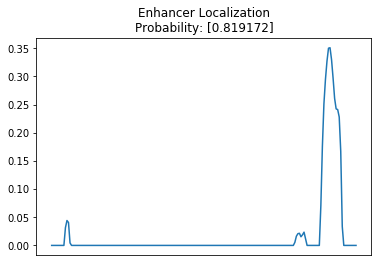

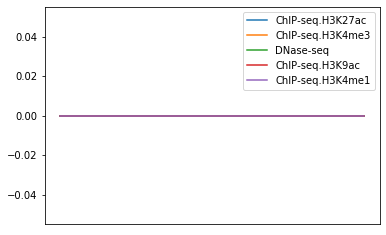

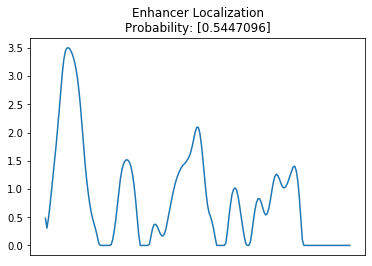

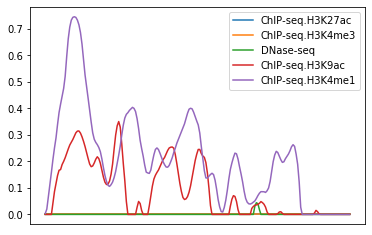

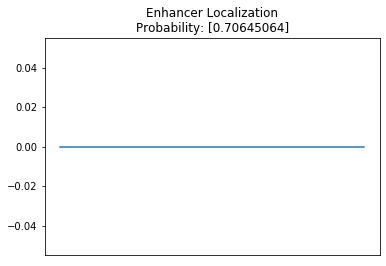

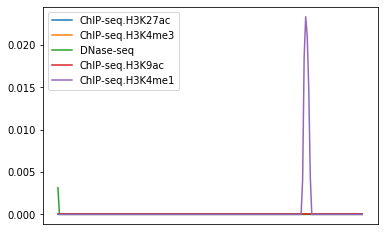

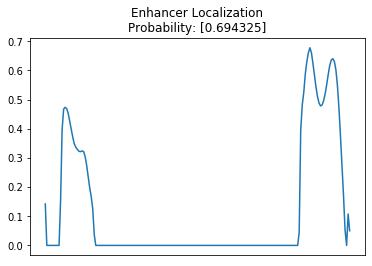

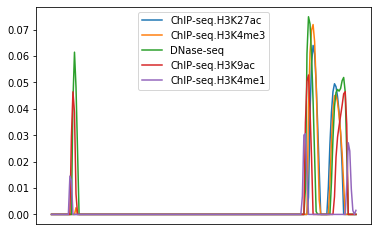

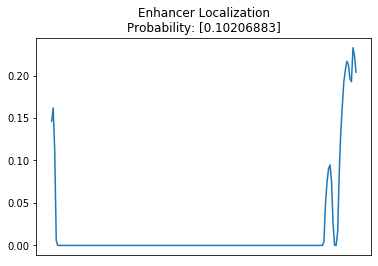

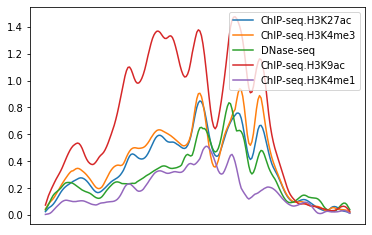

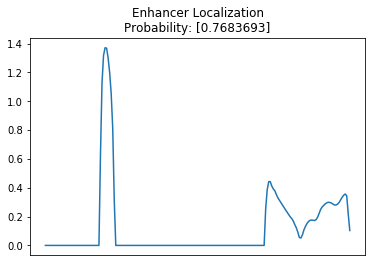

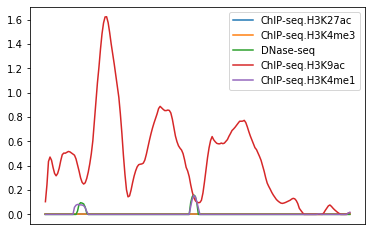

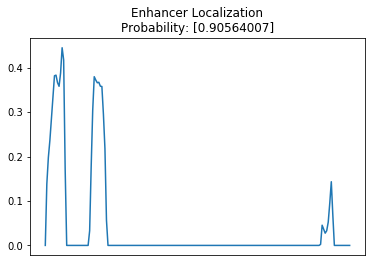

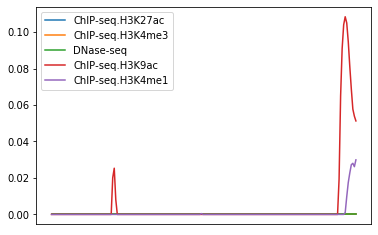

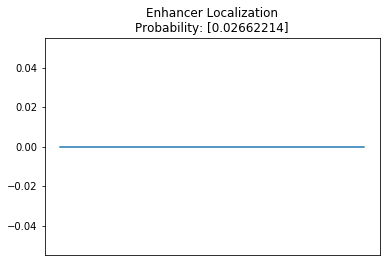

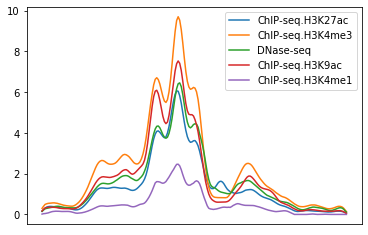

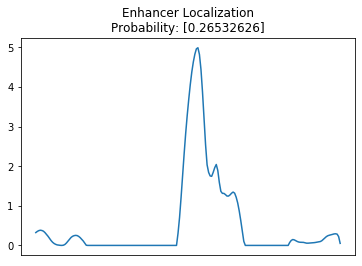

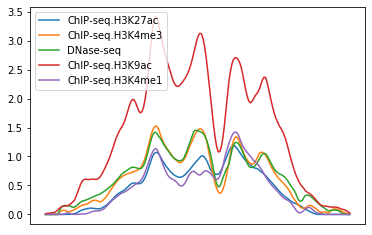

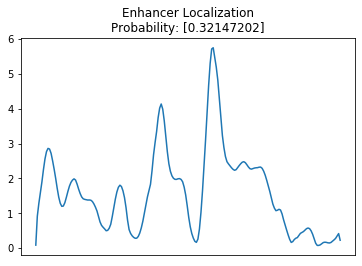

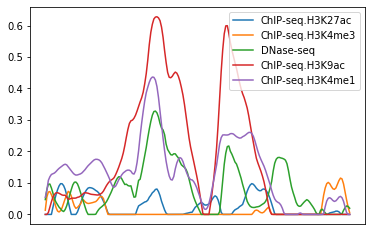

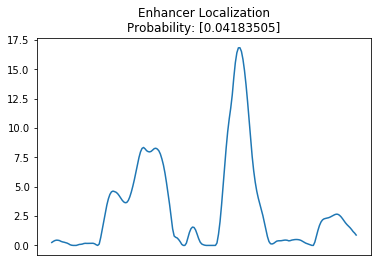

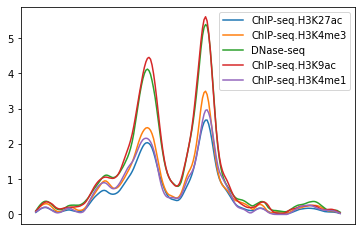

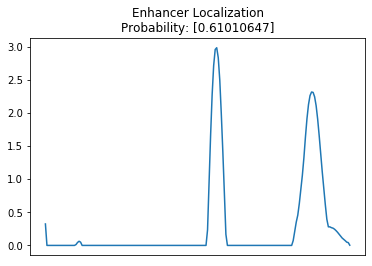

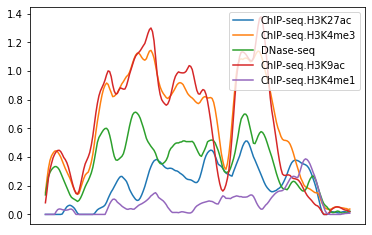

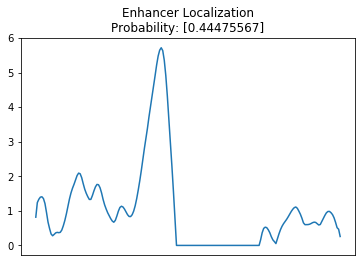

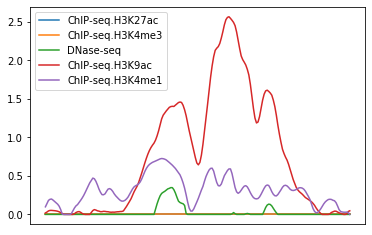

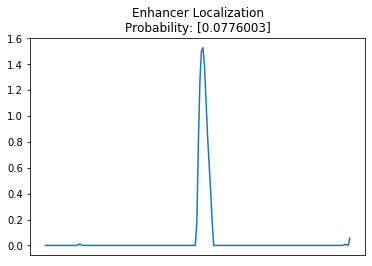

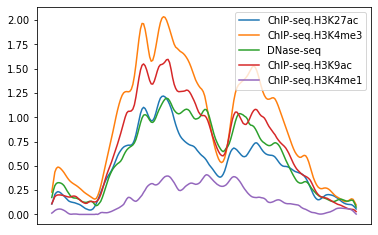

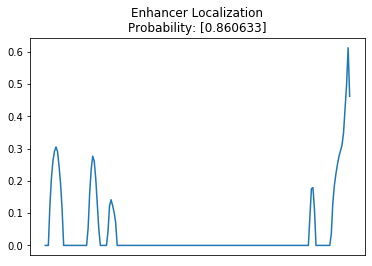

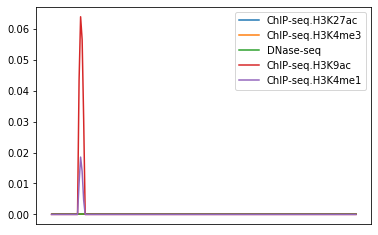

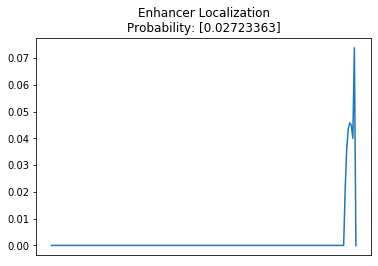

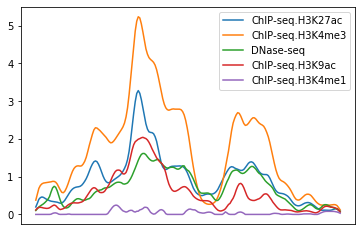

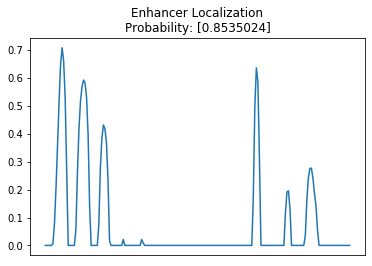

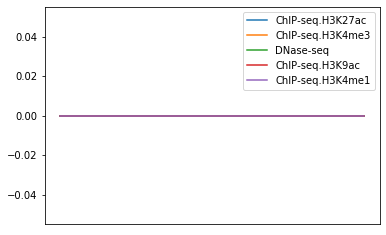

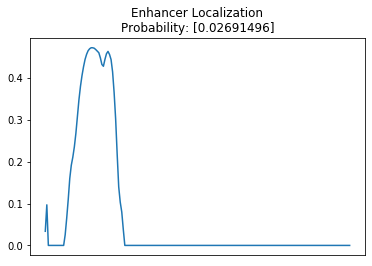

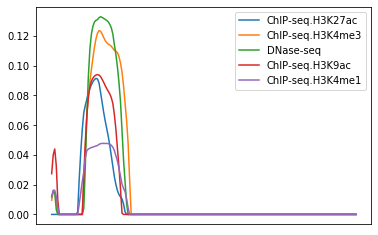

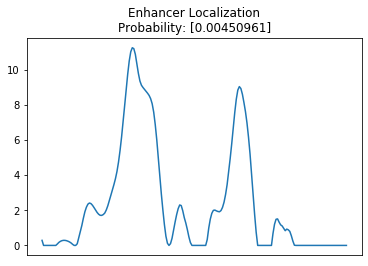

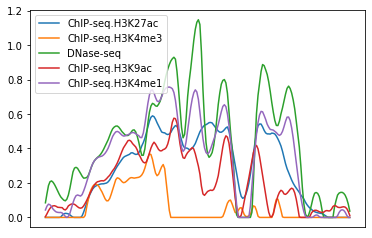

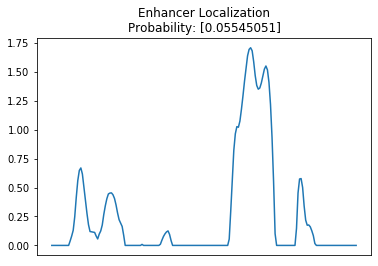

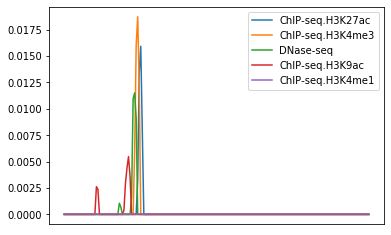

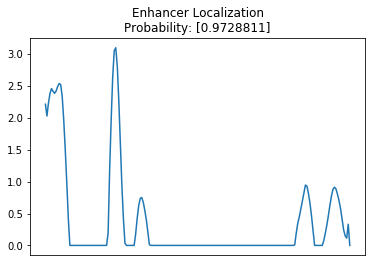

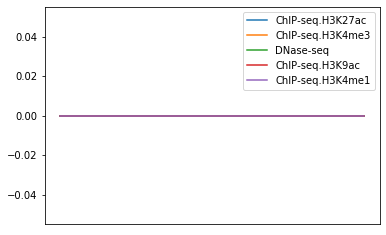

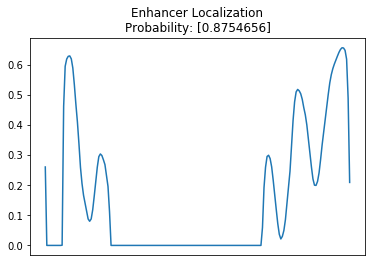

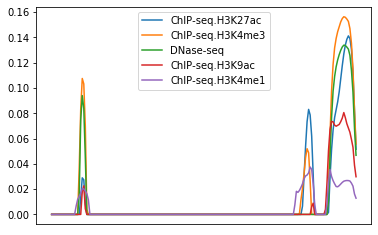

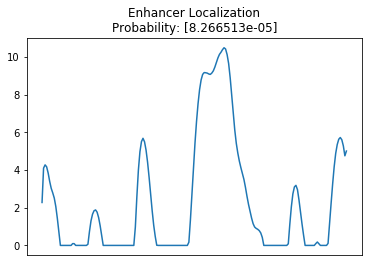

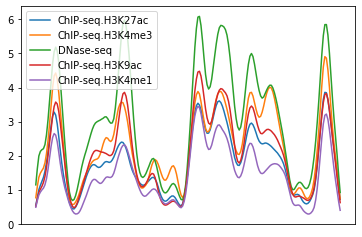

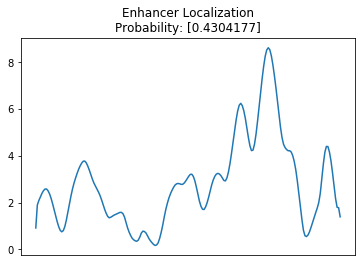

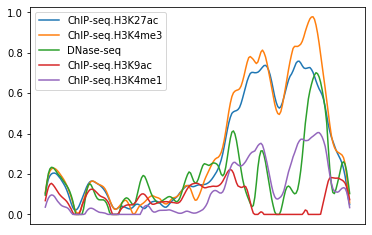

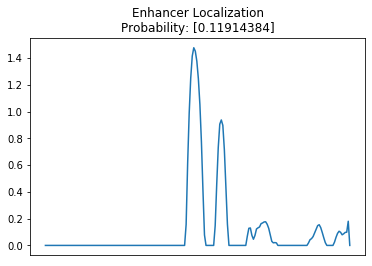

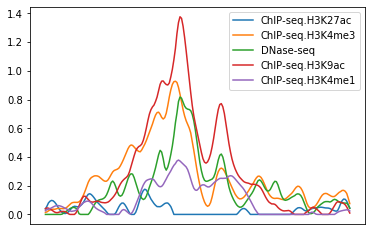

In [20]:
seq_names = ["H3K27ac", "H3K4me3", "DNase", "H3K9ac", "H3K4me1"]
for idx, item in enumerate(x_validation):
    plt.title("Enhancer Localization\nProbability: " + str(prediction_results[idx]))
    gradcam_1d = cam_pred_1d(model, np.expand_dims(x_validation[idx], axis=0))[0]
    #norm_gradcam_1d = gradcam_1d / np.max(gradcam_1d)
    plt.plot(gradcam_1d)
    plt.xticks([])
    plt.show();

    cam_5d = cam_pred_5d(model, np.expand_dims(x_validation[idx], axis=0))
    for i in [0,1,2,3,4]:
        plt.plot(cam_5d[i,], label=track_list[i].replace(".bigWig", "").replace("NPC.", "").replace(bw_file_dir, ""))
    plt.legend()
    plt.xticks([])
    plt.show();